# Setup

In [ ]:
import os
import torch
import torchvision
import zipfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Download Data

In [ ]:
# Download url of normal CT scans.
dataset_url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
download_url(dataset_url, '.')

# Download url of abnormal CT scans.
dataset_url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
download_url(dataset_url, '.')

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

# Loading data and preprocessing

In [ ]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [ ]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


# Build train and validation datasets

In [ ]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


In [ ]:
# Conversion of numpy array to Tensors
x_train=torch.from_numpy(x_train)
y_train=torch.from_numpy(y_train)
x_val=torch.from_numpy(x_val)
y_val=torch.from_numpy(y_val)


# Data augmentation

In [ ]:
import random

from scipy import ndimage



def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume


    augmented_volume = torch.tensor(scipy_rotate(volume), dtype=torch.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = torch.unsqueeze(volume,0)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = torch.unsqueeze(volume,0)
    return volume, label

In [ ]:
#Define dataset
train_dataset=TensorDataset(x_train,y_train)
val_dataset=TensorDataset(x_val,y_val)

In [ ]:
#Pre processing of data set
# Doubt :  any alternative for this : consuming more time
train_dataset=[train_preprocessing(*x) for x in train_dataset]
val_dataset=[validation_preprocessing(*x) for x in val_dataset]

In [ ]:
#Define dataloaders
batch_size=2
train_loader=DataLoader(train_dataset,batch_size,shuffle=True,prefetch_factor=2)
val_loader=DataLoader(val_dataset,batch_size,shuffle=True,prefetch_factor=2)


In [ ]:
for scans,labels in train_loader:
  print("scans shape : ",scans.shape)
  print("label shape : ",labels.shape)
  break

scans shape :  torch.Size([2, 1, 128, 128, 64])
label shape :  torch.Size([2])


# Visualize an augmented CT scan

Len of data :  2
images :  torch.Size([1, 128, 128, 64])
Dimension of the CT scan is: torch.Size([128, 128, 64])
Dimension of the CT scan is: torch.Size([128, 128])


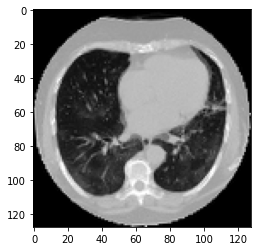

In [ ]:
for data,labels in train_loader:
  images= list(data)[0]
  print("Len of data : ",len(data))
  print("images : ",images.shape)
  image = images[0]
  print("Dimension of the CT scan is:", image.shape)
  print("Dimension of the CT scan is:", image[:, :, 30].shape)
  plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
  break

# Plot slices

In [ ]:
# def plot_slices(num_rows,num_cols,image):
#     num_slices=num_rows*num_cols
#     print(image[:,:,:num_slices].shape)
#     images=image[:,:,:num_slices].permute(2,0,1)
#     # print(len(list(x for x in images)))
#     # print(images.shape)
#     # images=np.array(x for x in images)
#     # images=torch.tensor(images,dtype=torch.float32)
#     # print(images[0].shape)
#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.set_xticks([]); ax.set_yticks([])
#     ax.imshow(make_grid(images, nrow=num_rows))

In [ ]:
# for data,labels in train_loader:
#   image= list(data)[0]
#   image=image[0]
#   print(image.shape)
#   plot_slices(4,10,image)
#   break

# Define 3D CNN


In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.binary_cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.binary_cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# Single conv block
def conv_block(in_channels, out_channels):
    layers = [nn.Conv3d(in_channels, out_channels, kernel_size=3),
              nn.ReLU(inplace=True),
              nn.MaxPool3d(2),
              nn.BatchNorm3d(out_channels)]
    return nn.Sequential(*layers)

In [ ]:
class CT_Image_classification(ImageClassificationBase):
  def __init__(self, in_channels=1, num_classes=2):
    super().__init__()
    self.conv1=conv_block(in_channels,64)
    self.conv2=conv_block(64,64)
    self.conv3=conv_block(64,128)
    self.conv4=conv_block(128,256)
    self.globalavgpool=nn.AvgPool3d((6, 6, 2))
    self.fc1=nn.Linear(256,512)
    self.dropout=nn.Dropout(0.3)
    self.fc2=nn.Linear(512,2)
    self.sigmoid=nn.Sigmoid()
  def forward(self,xb):
      print(xb.shape)
      out=self.conv1(xb)
      print(out.shape)
      out=self.conv2(out)
      print(out.shape)
      out=self.conv3(out)
      print(out.shape)
      out=self.conv4(out)
      print(out.shape)
      out=self.globalavgpool(out)
      print(out.shape)
      out.squeeze_()
      print(out.shape)
      out=self.fc1(out)
      print(out.shape)
      out=self.dropout(out)
      print(out.shape)
      out=self.fc2(out)
      print(out.shape)
      out=self.sigmoid(out)
      print(out.shape)
      return out

In [ ]:
model = CT_Image_classification()
model

CT_Image_classification(
  (conv1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
 
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
 
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Let's move our data loaders to the appropriate device.
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
model = to_device(CT_Image_classification(), device)

In [ ]:
model

CT_Image_classification(
  (conv1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (

# Training

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = torch.optim.ExponentialLR(optimizer, gamma=0.96)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
evaluate(model, val_loader)

torch.Size([2, 1, 128, 128, 64])
torch.Size([2, 64, 63, 63, 31])
torch.Size([2, 64, 30, 30, 14])
torch.Size([2, 128, 14, 14, 6])
torch.Size([2, 256, 6, 6, 2])
torch.Size([2, 256, 1, 1, 1])
torch.Size([2, 256])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 2])
torch.Size([2, 2])


ValueError: ignored

In [ ]:
# Hyper parameters
initial_learning_rate = 0.0001
epochs = 100
opt_func=torch.optim.Adam


In [ ]:
history = [evaluate(model, val_loader)]
history

RuntimeError: ignored

# Model(another way)

In [ ]:
# class Network(nn.Module):
#   def __init__(self, in_channels=1, num_classes=2):
#     super(Network, self).__init__()
#     self.conv1=conv_block(in_channels,64)
#     self.conv2=conv_block(64,64)
#     self.conv3=conv_block(64,128)
#     self.conv4=conv_block(128,256)
#     self.globalavgpool=nn.AdaptiveAvgPool3d(256)
#     self.fc1=nn.Linear(256,512)
#     self.dropout=nn.Dropout(0.3)
#     self.fc2=nn.Linear(512,1)
#     self.sigmoid=nn.Sigmoid()
#   def forward(self,xb):
#       out=self.conv1(xb)
#       out=self.conv2(out)
#       out=self.conv3(out)
#       out=self.conv4(out)
#       out=self.globalavgpool(out)
#       out=self.fc1(out)
#       out=self.dropout(out)
#       out=self.fc2(out)
#       out=self.sigmoid(out)
#       return out

In [ ]:
# from torchsample.modules import ModuleTrainer
# trainer = ModuleTrainer(model)
# model = ModuleTrainer(Network())
# model.compile(loss='binary_cross_entropy', optimizer='adam')
# callbacks = [EarlyStopping(monitor='val_loss', patience=15)]
# model.set_callbacks(callbacks)
# model.fit(x_train, y_train, val_data=(x_test, y_test),num_epoch=100, batch_size=2, verbose=1)
# loss = model.evaluate(x_train, y_train)
# y_pred = model.predict(x_train)

ModuleNotFoundError: ignored